# Heart Failure Clinical Records
This notebook will take the cleaned data and create, train, and save various machine learning models.

All of the models will be implemented using a pipeline so that it can be exported and easily used in a Flask application.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Technically here I should only be using `serum_creatinine` and `ejection_fraction` for predictors but I
# get average results around 74% accurate.  Including `age` bumps it up a little, which makes sense.
# Adding `time` really helps but that's sketchy as discussed in the EDA.

all_data = pd.read_csv('./data/cleaned.csv', usecols=['serum_creatinine', 'ejection_fraction', 'age', 'DEATH_EVENT'])

In [2]:
# all_data['serum_creatinine'] = 10 ** all_data.serum_creatinine
# all_data['ejection_fraction'] = 10 ** all_data.ejection_fraction

## Helper Functions

Draws a learning curve to help visualize model progress and quality over time.

In [3]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, rstate, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True,
        shuffle=True, # Without this it sometimes breaks!
        random_state=rstate # Needed when shuffle=True for consistency.
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Data Preparation
Splitting the data into train and test sets.  Values are chosen arbitrarily but sensibly.

In [4]:
from sklearn.model_selection import train_test_split

X = all_data.drop('DEATH_EVENT', axis=1)
y = all_data['DEATH_EVENT']

TEST_SIZE = 0.3
RANDOM_STATE = 4242
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [5]:
# Roughly taken from:
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

RESAMPLE_METHOD = 'synthetic' # ['oversample', 'synthetic', emptystr]

if RESAMPLE_METHOD == 'oversample':
    print('Resampling enabled; original balance:')
    print(y_train.value_counts())
    
    # Join training data back together.
    resamp_joined = pd.concat([X_train, y_train], axis=1)

    # Separate classes.
    resamp_died = resamp_joined[resamp_joined['DEATH_EVENT'] == 1]
    resamp_survived = resamp_joined[resamp_joined['DEATH_EVENT'] == 0]

    # Upsample minority (died).
    resamp_died_upsampled = resample(
        resamp_died,
        replace=True, # (use replacement)
        n_samples=len(resamp_survived), # (match number of majority cases)
        random_state=RANDOM_STATE
    )

    # Combine majority and upsampled majority.
    resamp_upsampled = pd.concat([resamp_survived, resamp_died_upsampled])

    # Check class counts.
    print('Resampling complete; new balance:')
    print(resamp_upsampled['DEATH_EVENT'].value_counts())

    # Remake X_train, y_train.
    X_train = resamp_upsampled.drop('DEATH_EVENT', axis=1)
    y_train = resamp_upsampled['DEATH_EVENT']

if RESAMPLE_METHOD == 'synthetic':
    print('Synthetic sampling enabled; original balance:')
    print(y_train.value_counts())
    
    smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
    X_train, y_train = smote.fit_sample(X_train, y_train)
    
    print('Synthetic sampling complete; new balance:')
    print(y_train.value_counts())

Synthetic sampling enabled; original balance:
0    142
1     67
Name: DEATH_EVENT, dtype: int64
Synthetic sampling complete; new balance:
1    142
0    142
Name: DEATH_EVENT, dtype: int64


In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV # Used by all as well.
from sklearn.pipeline import Pipeline # Same^
from sklearn.preprocessing import StandardScaler

# This is shared between all models.
kfold = StratifiedKFold(n_splits=3)

In [7]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
SCORING_METRICS = [
    'accuracy', # Doesn't work well on imbalanced data, but nice to have around.
    'f1',       # Precision+Recall combined (kinda). Perfect for binary classification, which is what we have.
    'roc_auc'   # Again good for classification (TPR & FPR), but not good with imbalanced datasets.
]
MAIN_METRIC = 'f1'

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

# Pipeline.
pl_logreg = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression())
])

# Randomized search space.
params_logreg = {
    'lr__C': np.linspace(0.0001, 1.0, 30),
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [100, 200, 400],
    'lr__solver': ['liblinear'], # Good for small datasets.
    'lr__random_state': [RANDOM_STATE]
}
cv_logreg = RandomizedSearchCV(
    pl_logreg,
    params_logreg,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=200, n_jobs=-1
)

cv_logreg.fit(X_train, y_train)

/Users/daniel/.virtualenv/default/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 180 is smaller than n_iter=200. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('lr', LogisticRegression())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'lr__C': array([1.00000000e-04, 3.45793103e-02, 6.90586207e-02, 1.03537931e-01,
       1.38017241e-01, 1.72496552e-01, 2.06975862e-01, 2.41455172e-01,
       2.75934483e...
       5.51768966e-01, 5.86248276e-01, 6.20727586e-01, 6.55206897e-01,
       6.89686207e-01, 7.24165517e-01, 7.58644828e-01, 7.93124138e-01,
       8.27603448e-01, 8.62082759e-01, 8.96562069e-01, 9.31041379e-01,
       9.65520690e-01, 1.00000000e+00]),
                                        'lr__max_iter': [100, 200, 400],
                                        'lr__penalty': ['l1', 'l2'],
                                        'lr__random_state': [4242],
                                        'lr__sol

Best parameters: {'lr__solver': 'liblinear', 'lr__random_state': 4242, 'lr__penalty': 'l2', 'lr__max_iter': 100, 'lr__C': 0.03457931034482759}
Mean accuracy: 0.7173802413836008
Mean F1: 0.6890962960185502
Mean ROC: 0.7798577054306457


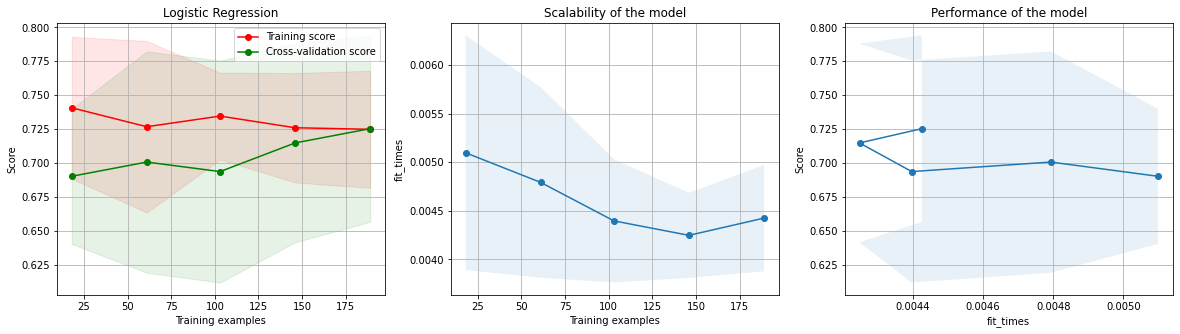

In [9]:
print(f'Best parameters: {cv_logreg.best_params_}')

mean_accuracy = np.mean(cv_logreg.cv_results_['mean_test_accuracy'])
print(f'Mean accuracy: {mean_accuracy}')

mean_f1 = np.mean(cv_logreg.cv_results_['mean_test_f1'])
print(f'Mean F1: {mean_f1}')

mean_roc = np.mean(cv_logreg.cv_results_['mean_test_roc_auc'])
print(f'Mean ROC: {mean_roc}')

plot_learning_curve(cv_logreg.best_estimator_, 'Logistic Regression', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7333333333333333
F1 Score: 0.6470588235294118
 ROC AUC: 0.7399660825325043


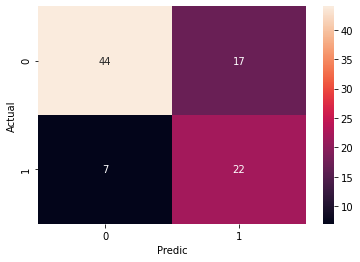

In [10]:
# todo: move these above somewhere
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

preds_logreg = cv_logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, preds_logreg)}')
print(f'F1 Score: {f1_score(y_test, preds_logreg)}')
print(f' ROC AUC: {roc_auc_score(y_test, preds_logreg)}')

conf_logreg = pd.DataFrame({
    'Actual': y_test,
    'Predic': preds_logreg
})
sns.heatmap(pd.crosstab(conf_logreg['Actual'], conf_logreg['Predic'], rownames=['Actual'], colnames=['Predic']), annot=True)
plt.show()

In [11]:
import joblib

joblib.dump(cv_logreg, 'logreg.pkl')

['logreg.pkl']

## SVC

In [11]:
from sklearn.svm import SVC

pl_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
params_svc = {
    'svc__C': np.linspace(0.0001, 1.0, 30),
    'svc__gamma': np.linspace(0.0001, 1.0, 30),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv_svc = RandomizedSearchCV(
    pl_svc,
    params_svc,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
)
cv_svc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-04, 3.45793103e-02, 6.90586207e-02, 1.03537931e-01,
       1.38017241e-01, 1.72496552e-01, 2.06975862e-01, 2.41455172e-01,
       2.75...
       4.13851724e-01, 4.48331034e-01, 4.82810345e-01, 5.17289655e-01,
       5.51768966e-01, 5.86248276e-01, 6.20727586e-01, 6.55206897e-01,
       6.89686207e-01, 7.24165517e-01, 7.58644828e-01, 7.93124138e-01,
       8.27603448e-01, 8.62082759e-01, 8.96562069e-01, 9.31041379e-01,
       9.65520690e-01, 1.00000000e+00]),
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=4242,

Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 0.41385172413793103, 'svc__C': 0.7931241379310345}
Mean accuracy: 0.7147942386831276
Mean F1: 0.6790864969501149
Mean ROC: 0.7922031702484376


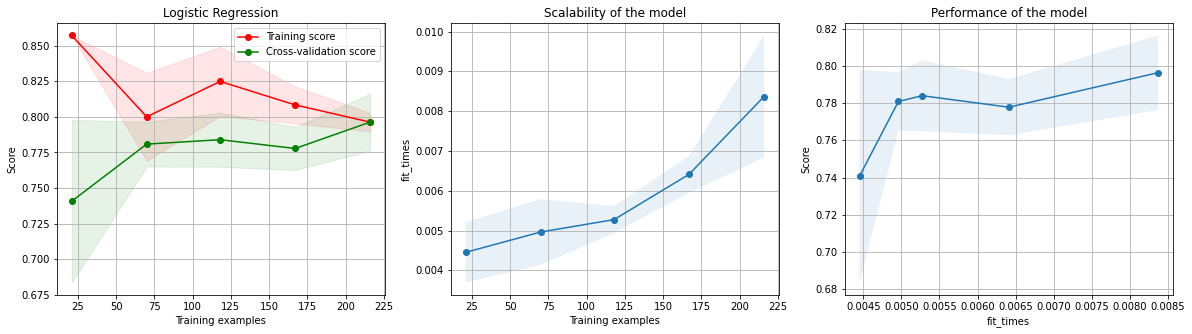

In [12]:
print(f'Best parameters: {cv_svc.best_params_}')

mean_accuracy = np.mean(cv_svc.cv_results_['mean_test_accuracy'])
print(f'Mean accuracy: {mean_accuracy}')

mean_f1 = np.mean(cv_svc.cv_results_['mean_test_f1'])
print(f'Mean F1: {mean_f1}')

mean_roc = np.mean(cv_svc.cv_results_['mean_test_roc_auc'])
print(f'Mean ROC: {mean_roc}')

plot_learning_curve(cv_svc.best_estimator_, 'Logistic Regression', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7666666666666667
F1 Score: 0.6666666666666666
 ROC AUC: 0.7586649550706034


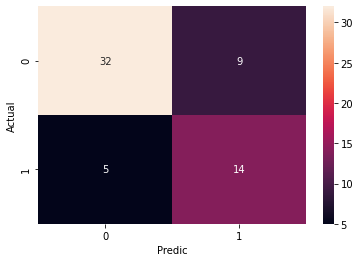

In [13]:
preds_svc = cv_svc.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, preds_svc)}')
print(f'F1 Score: {f1_score(y_test, preds_svc)}')
print(f' ROC AUC: {roc_auc_score(y_test, preds_svc)}')

conf_svc = pd.DataFrame({
    'Actual': y_test,
    'Predic': preds_svc
})
sns.heatmap(pd.crosstab(conf_svc['Actual'], conf_svc['Predic'], rownames=['Actual'], colnames=['Predic']), annot=True)
plt.show()

## Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

pl_gboost = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])
params_gboost = {
    'gb__n_estimators': [100, 200, 400],
    'gb__max_features': ['log2', 'auto'],
    'gb__min_samples_leaf': [1, 2, 3],
    'gb__learning_rate': np.linspace(0.001, 1.0, 30),
    'gb__max_depth': [2, 4, 6, 8, 10]
}
cv_gboost = RandomizedSearchCV(
    pl_gboost,
    params_gboost,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
)
cv_gboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'gb__learning_rate': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.3...
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ]),
                                        'gb__max_depth': [2, 4, 6, 8, 10],
                                        'gb__max_features': ['log2', 'auto'],
                                        'gb__min_samples_leaf': [1, 2, 3],
                           

Best parameters: {'gb__n_estimators': 200, 'gb__min_samples_leaf': 2, 'gb__max_features': 'log2', 'gb__max_depth': 10, 'gb__learning_rate': 0.9311034482758621}
Mean accuracy: 0.859320987654321
Mean F1: 0.8621711987386043
Mean ROC: 0.9264422344154855


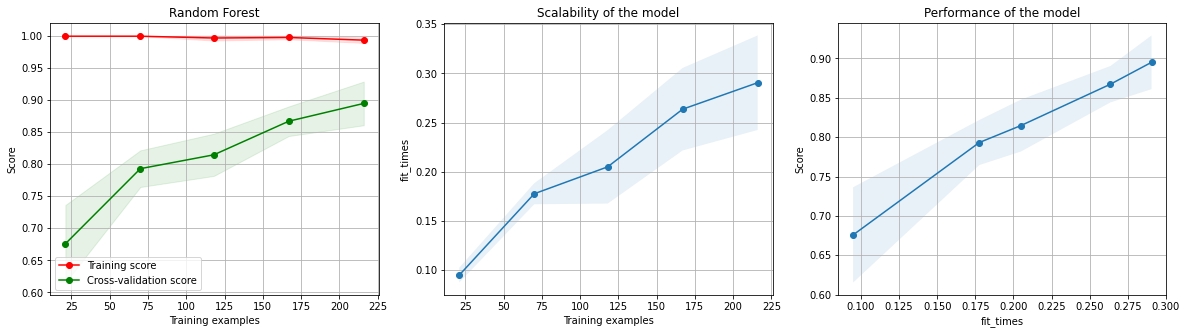

In [15]:
print(f'Best parameters: {cv_gboost.best_params_}')

mean_accuracy = np.mean(cv_gboost.cv_results_['mean_test_accuracy'])
print(f'Mean accuracy: {mean_accuracy}')

mean_f1 = np.mean(cv_gboost.cv_results_['mean_test_f1'])
print(f'Mean F1: {mean_f1}')

mean_roc = np.mean(cv_gboost.cv_results_['mean_test_roc_auc'])
print(f'Mean ROC: {mean_roc}')

plot_learning_curve(cv_gboost.best_estimator_, 'Random Forest', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.6666666666666666
F1 Score: 0.37499999999999994
 ROC AUC: 0.5725288831835686


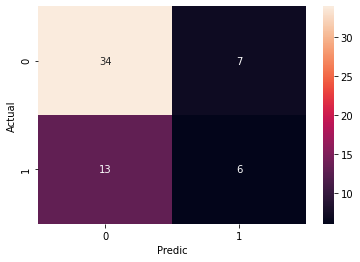

In [16]:
preds_gboost = cv_gboost.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, preds_gboost)}')
print(f'F1 Score: {f1_score(y_test, preds_gboost)}')
print(f' ROC AUC: {roc_auc_score(y_test, preds_gboost)}')

conf_forest = pd.DataFrame({
    'Actual': y_test,
    'Predic': preds_gboost
})
sns.heatmap(pd.crosstab(conf_forest['Actual'], conf_forest['Predic'], rownames=['Actual'], colnames=['Predic']), annot=True)
plt.show()

## Random Forest

In [17]:
# from sklearn.ensemble import RandomForestClassifier

# pl_forest = Pipeline([
#     ('scaler', StandardScaler()),
#     ('rf', RandomForestClassifier())
# ])
# params_forest = {
#     'rf__n_estimators': [100, 200, 400, 800],
#     'rf__max_features': ['auto', 2, 3],
#     'rf__min_samples_leaf': [1, 2, 5, 10],
#     'rf__max_depth': [2, 4, 8, 16],
#     'rf__min_samples_split': [2, 5, 10, 15]
# }
# cv_forest = RandomizedSearchCV(
#     pl_forest,
#     params_forest,
#     cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
# )
# cv_forest.fit(X_train, y_train)

In [18]:
# print(f'Best parameters: {cv_forest.best_params_}')

# mean_accuracy = np.mean(cv_forest.cv_results_['mean_test_accuracy'])
# print(f'Mean accuracy: {mean_accuracy}')

# mean_f1 = np.mean(cv_forest.cv_results_['mean_test_f1'])
# print(f'Mean F1: {mean_f1}')

# mean_roc = np.mean(cv_forest.cv_results_['mean_test_roc_auc'])
# print(f'Mean ROC: {mean_roc}')

# plot_learning_curve(cv_forest.best_estimator_, 'Random Forest', X_train, y_train, RANDOM_STATE, cv=kfold)
# plt.show()

In [19]:
# preds_forest = cv_forest.predict(X_test)

# print(f'Accuracy: {accuracy_score(y_test, preds_forest)}')
# print(f'F1 Score: {f1_score(y_test, preds_forest)}')
# print(f' ROC AUC: {roc_auc_score(y_test, preds_forest)}')

# conf_forest = pd.DataFrame({
#     'Actual': y_test,
#     'Predic': preds_forest
# })
# sns.heatmap(pd.crosstab(conf_forest['Actual'], conf_forest['Predic'], rownames=['Actual'], colnames=['Predic']), annot=True)
# plt.show()

## Voting

In [20]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[
    ('logreg', cv_logreg.best_estimator_),
    ('svc', cv_svc.best_estimator_),
    ('gboost', cv_gboost.best_estimator_)
], voting='soft', n_jobs=-1)

voting = voting.fit(X_train, y_train)

Accuracy: 0.7166666666666667
F1 Score: 0.5142857142857142
 ROC AUC: 0.6514762516046213


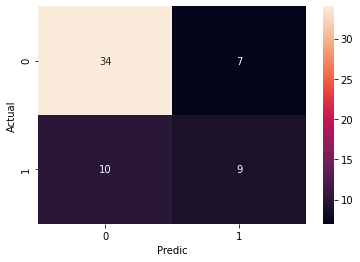

In [21]:
preds_voting = voting.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, preds_voting)}')
print(f'F1 Score: {f1_score(y_test, preds_voting)}')
print(f' ROC AUC: {roc_auc_score(y_test, preds_voting)}')

conf_forest = pd.DataFrame({
    'Actual': y_test,
    'Predic': preds_voting
})
sns.heatmap(pd.crosstab(conf_forest['Actual'], conf_forest['Predic'], rownames=['Actual'], colnames=['Predic']), annot=True)
plt.show()